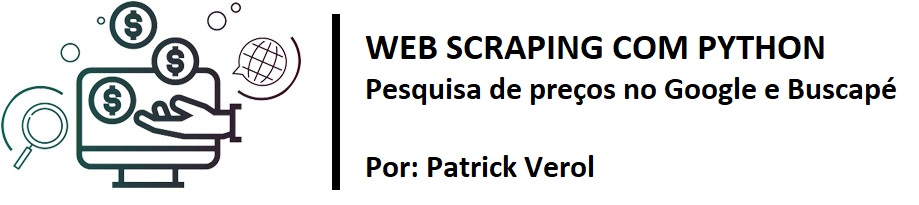

## Objetivo: 

- Criar um programa que automatize a busca de preços nos sites do Google e Buscapé, coloque os dados em excel e envie por e-mail.

## Descrição:

- O projeto teve como base a problemática do setor de compras de uma empresa, que precisa pesquisar diariamente preços de insumos/produtos distintos, e realizar diversas outras tarefas no dia. Com a automatização do sistema de busca de preços, sobrará muito mais tempo para dar atenção a outras tarefas mais estratégicas, além disto, variações nos preços de fornecedores e possíveis promoções, poderão ser melhor aproveitadas, pois o modelo realizará novas buscas em questão de minutos.<p><p>

- Para o funcionamento do programa, será criada uma planilha em excel, com os nomes dos insumos e alguns critérios para realização do busca, como a definição de um preço mínimo e máximo para cada produto (para evitar produtos usados, ou muitos caros), e também de alguns termos banidos (para minimizar a busca de insumos errados).<p><p>

- Após a realização de todas as buscas, o modelo enviará para o e-mail definido, uma lista dos produtos que estão dentro dos critérios estabelecidos, assim como o arquivo excel em anexo.

## ETAPAS:

1. Importação
2. Definição das funções de busca no Google e no Buscapé
3. Realizar as pesquisas e armazenar os dados em um Dataframe
4. Exportar o Dataframe para o Excel
5. Enviar para o e-mail

## 1. Importação

In [1]:
# criar um navegador
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By

import pandas as pd

# criar o navegador
nav = webdriver.Chrome()

# importar/visualizar a base de dados
tabela_produtos = pd.read_excel("buscas.xlsx")
display(tabela_produtos)

,Nome,Termos banidos,Preço mínimo,Preço máximo
0,iphone 12 64gb,mini watch,3000,3500
1,rtx 3060,zota galax,4000,4500


## 2. Definição das funções de busca no Google e no Buscapé

In [2]:
def busca_google_shopping(nav, produto, termos_banidos, preco_minimo, preco_maximo):

    # entrar no google
    nav.get("https://www.google.com/")
    
    # tratamento de erros
    produto = produto.lower()
    termos_banidos = termos_banidos.lower()
    lista_termos_banidos = termos_banidos.split(" ")
    lista_termos_produto = produto.split(" ")
    
    # pesquisar o nome do produto no google
    nav.find_element(By.XPATH, '/html/body/div[1]/div[3]/form/div[1]/div[1]/div[1]/div/div[2]/input').send_keys(produto)
    nav.find_element(By.XPATH, '/html/body/div[1]/div[3]/form/div[1]/div[1]/div[1]/div/div[2]/input').send_keys(Keys.ENTER)

    # clicar na aba shopping
    elementos = nav.find_elements(By.CLASS_NAME, 'hdtb-mitem')
    for item in elementos:
        if "Shopping" in item.text:
            item.click()
            break

    # pegar a lista de resultados da busca no google shopping
    lista_resultados = nav.find_elements(By.CLASS_NAME, 'sh-dgr__grid-result')
    
    # para cada resultado, ele vai verificar se o resultado corresponde a todas as nossas condições
    lista_ofertas = []  # lista que a função vai me dar como resposta

    for resultado in lista_resultados:
        try:
            nome = resultado.find_element(By.CLASS_NAME, 'Xjkr3b').text
            nome = nome.lower()

            # verificação do nome - se o nome tem algum termo banido
            tem_termos_banidos = False
            for palavra in lista_termos_banidos:
                if palavra in nome:
                    tem_termos_banidos = True

            # verificação do nome - se o nome tem todos os termos do nome do produto
            tem_todos_termos_produto = True
            for palavra in lista_termos_produto:
                if palavra not in nome:
                    tem_todos_termos_produto = False

            # se tem_termos_banidos = False e o tem_todos_termos_produto = True
            if tem_termos_banidos == False and tem_todos_termos_produto == True:
                preco = resultado.find_element(By.CLASS_NAME, 'a8Pemb').text
                preco = preco.replace('R$', '').replace(' ', '').replace('.', '').replace(',', '.')
                preco = float(preco)

                # verificando se o preço ta dentro do mínimo e máximo
                preco_maximo = float(preco_maximo)
                preco_minimo = float(preco_minimo)
                if preco_minimo <= preco <= preco_maximo:
                    elemento_link = resultado.find_element(By.CLASS_NAME, 'aULzUe')
                    elemento_pai = elemento_link.find_element(By.XPATH, '..')
                    link = elemento_pai.get_attribute('href')
                    lista_ofertas.append((nome, preco, link))
        except:
            pass    
    return lista_ofertas



def busca_buscape(nav, produto, termos_banidos, preco_minimo, preco_maximo):
    
    import time
    
    # tratar os valores da função
    produto = produto.lower()
    termos_banidos = termos_banidos.lower()
    lista_termos_banidos = termos_banidos.split(" ")
    lista_termos_produto = produto.split(" ")
    
    preco_minimo = float(preco_minimo)
    preco_maximo = float(preco_maximo)
    
    # entrar no buscape
    nav.get('https://www.buscape.com.br/')
    
    # pesquisar pelo produto no buscape
    nav.find_element(By.XPATH, '//*[@id="new-header"]/div[1]/div/div/div[3]/div/div/div[1]/input').send_keys(produto, Keys.ENTER)

    # pegar a lista de resultados da busca do buscape
    time.sleep(5)  # esperar a página carregar -> Correção do Erro 'stale element reference'
    lista_resultados = nav.find_elements(By.CLASS_NAME, 'Cell_Content__fT5st')
    
    # para cada resultado
    lista_ofertas = []
    
    for resultado in lista_resultados:
        try:
            preco = resultado.find_element(By.CLASS_NAME, 'CellPrice_MainValue__JXsj_').text
            nome = resultado.get_attribute('title')
            nome = nome.lower()
            link = resultado.get_attribute('href')
            
            # verificação do nome - se o nome tem algum termo banido
            tem_termos_banidos = False
            for palavra in lista_termos_banidos:
                if palavra in nome:
                    tem_termos_banidos = True
        
            # verificação do nome - se o nome tem todos os termos do nome do produto
            tem_todos_termos_produto = True
            for palavra in lista_termos_produto:
                if palavra not in nome:
                    tem_todos_termos_produto = False
        
            # se tem_termos_banidos = False e o tem_todos_termos_produto = True
            if tem_termos_banidos == False and tem_todos_termos_produto == True:
                preco = preco.replace('R$', '').replace(' ', '').replace('.', '').replace(',', '.')
                preco = float(preco)
                
                # verificando se o preço ta dentro do mínimo e máximo
                if preco_minimo <= preco <= preco_maximo:
                    lista_ofertas.append((nome, preco, link))
        except:
            pass
    return lista_ofertas

## 3. Realizar as pesquisas e armazenar os dados em um Dataframe

In [3]:
tabela_de_ofertas = pd.DataFrame()

for linha in tabela_produtos.index:
    
    # Rodando cada um dos itens da tabela de produtos
    produto = tabela_produtos.loc[linha, 'Nome']
    termos_banidos = tabela_produtos.loc[linha, 'Termos banidos']
    preco_minimo = tabela_produtos.loc[linha, 'Preço mínimo']
    preco_maximo = tabela_produtos.loc[linha, 'Preço máximo']
    
    # Realizando a pesquisa através da função e Criando a tabela de ofertas do Google
    lista_ofertas_google_shopping = busca_google_shopping(nav, produto, termos_banidos, preco_minimo, preco_maximo)
    
    if lista_ofertas_google_shopping:
        tabela_google_shopping = pd.DataFrame(lista_ofertas_google_shopping, columns=['Produto', 'Preço', 'Link'])
        tabela_de_ofertas = tabela_de_ofertas.append(tabela_google_shopping)
    else:
        tabela_google_shopping = None
    
    # Realizando a pesquisa através da função e Criando a tabela de ofertas do Buscapé
    lista_ofertas_buscape = busca_buscape(nav, produto, termos_banidos, preco_minimo, preco_maximo)
    if lista_ofertas_buscape:
        tabela_buscape = pd.DataFrame(lista_ofertas_buscape, columns=['Produto', 'Preço', 'Link'])
        tabela_de_ofertas = tabela_de_ofertas.append(tabela_buscape)
    else:
        tabela_buscape = None

    display(tabela_google_shopping)
    display(tabela_buscape)

tabela_de_ofertas = tabela_de_ofertas.reset_index()
tabela_de_ofertas.drop(labels='index', axis=1, inplace=True)
display(tabela_de_ofertas)

,Produto,Preço,Link
0,iphone 12 azul 64gb | celular apple | usado,3500.00,https://www.google.com/url?url=https://www.enj...
1,iphone 11 apple (lacrado) câmera dupla de 12mp...,3499.90,https://www.google.com/url?url=https://ropshop...
2,iphone 11 apple (lacrado) câmera dupla de 12mp...,3499.90,https://www.google.com/url?url=https://ropshop...
3,iphone 11 apple (lacrado) câmera dupla de 12mp...,3499.90,https://www.google.com/url?url=https://ropshop...
4,"iphone 11 apple tela 6,1"" 4g câmera 12mp ios 6...",3299.00,https://www.google.com/url?url=https://www.box...
5,"iphone xr apple (64gb) preto tela 6,1” ios 12 ...",3349.99,https://www.google.com/url?url=https://inteclo...
6,"iphone 11 apple tela 6,1"" 4g câmera 12mp ios 6...",3299.00,https://www.google.com/url?url=https://www.box...


,Produto,Preço,Link
0,smartphone apple iphone se 3 4 gb 64gb 12.0 mp...,3423.11,https://www.buscape.com.br/celular/smartphone-...


,Produto,Preço,Link
0,placa de vídeo palit geforce rtx 3060 12gb - g...,4068.79,https://www.google.com/url?url=https://www.com...
1,placa de vídeo geforce rtx 3060 v2 dual 12gb g...,4261.43,https://www.google.com/url?url=https://www.kab...
2,placa de vídeo asus tuf rtx 3060 oc v2 12gb ga...,4299.90,https://www.google.com/url?url=https://www.pic...
3,placa de vídeo colorful igame geforce rtx 3060...,4088.13,https://www.google.com/url?url=https://www.ter...
4,placa de video rtx 3060 ventus 3x oc 12gb msi,4199.90,https://www.google.com/url?url=https://www.kab...
5,placa de vídeo colorful igame rtx 3060 advance...,4369.14,https://www.google.com/url?url=https://www.ter...
6,placa de video colorful igame geforce rtx 3060...,4115.00,https://www.google.com/url?url=https://www.pon...
7,brandnew original gigabyte geforce rtx 3060ti ...,4102.93,https://www.google.com/url?url=https://s.click...


,Produto,Preço,Link
0,placa de video nvidia geforce rtx 3060 12 gb g...,4106.77,https://www.buscape.com.br/placa-de-video/plac...
1,placa de vídeo asus tuf gaming - geforce rtx 3...,4499.90,https://www.buscape.com.br/lead?oid=507880660&...
2,placa de vídeo asus tuf gaming - geforce rtx 3...,4199.00,https://www.buscape.com.br/lead?oid=419400087&...
3,placa de video colorful igame geforce rtx 3060...,4199.00,https://www.buscape.com.br/lead?oid=365855199&...
4,placa de video colorful igame geforce rtx 3060...,4199.00,https://www.buscape.com.br/lead?oid=519818203&...
5,placa de mineração rx 580 8gb rtx 3060 6gb 256...,4437.71,https://www.buscape.com.br/lead?oid=425325094&...
6,placa de video colorful igame geforce rtx 3060...,4199.00,https://www.buscape.com.br/lead?oid=373007869&...
7,placa de vídeo asus geforce rtx 3060 dual lhr ...,4420.72,https://www.buscape.com.br/lead?oid=610205722&...


,Produto,Preço,Link
0,iphone 12 azul 64gb | celular apple | usado,3500.00,https://www.google.com/url?url=https://www.enj...
1,iphone 11 apple (lacrado) câmera dupla de 12mp...,3499.90,https://www.google.com/url?url=https://ropshop...
2,iphone 11 apple (lacrado) câmera dupla de 12mp...,3499.90,https://www.google.com/url?url=https://ropshop...
3,iphone 11 apple (lacrado) câmera dupla de 12mp...,3499.90,https://www.google.com/url?url=https://ropshop...
4,"iphone 11 apple tela 6,1"" 4g câmera 12mp ios 6...",3299.00,https://www.google.com/url?url=https://www.box...
5,"iphone xr apple (64gb) preto tela 6,1” ios 12 ...",3349.99,https://www.google.com/url?url=https://inteclo...
6,"iphone 11 apple tela 6,1"" 4g câmera 12mp ios 6...",3299.00,https://www.google.com/url?url=https://www.box...
7,smartphone apple iphone se 3 4 gb 64gb 12.0 mp...,3423.11,https://www.buscape.com.br/celular/smartphone-...
8,placa de vídeo palit geforce rtx 3060 12gb - g...,4068.79,https://www.google.com/url?url=https://www.com...
9,placa de vídeo geforce rtx 3060 v2 dual 12gb g...,4261.43,https://www.google.com/url?url=https://www.kab...


## 4. Exportar o Dataframe para o Excel

In [4]:
# exportar para excel
tabela_de_ofertas.to_excel("Ofertas.xlsx", index=False)

## 5. Enviar para o e-mail

In [ ]:
# enviar por e-mail o resultado da tabela

import win32com.client as win32
import pathlib

# verificando se existe alguma oferta dentro da tabela de ofertas
if len(tabela_de_ofertas.index) > 0:
    outlook = win32.Dispatch('outlook.application')
    mail = outlook.CreateItem(0)
    mail.To = f'patrickverol2@gmail.com'
    mail.Subject = f'Lista de ofertas'
    mail.HTMLBody = f'''
    <p>Prezados,</p>
    <p>Encontramos alguns produtos em oferta dentro da faixa de preço desejada. Segue tabela abaixo com detalhes:</p>
    {tabela_de_ofertas.to_html(index=False)}
    <p>Qualquer dúvida estou a disposição</p>
    <p>Att, Patrick.</p>
    '''
    caminho = pathlib.Path(r'C:\Users\PICHAU\Documents\16. PYTHON\14. Projeto 2 - Automação Web')
    attachment  = caminho / f'Ofertas.xlsx'
    mail.Attachments.Add(str(attachment))
    mail.Send()
    
    print('E-mail enviado com sucesso!')
    
nav.quit()